In [2]:
## read feature data file 
import pandas as pd

features = pd.read_csv('features.csv') #,header=None) 
features.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,emotion,emotionID
0,0,45,179,48,210,52,241,60,272,76,...,209,264,179,258,168,258,156,256,neutral,0
1,1,43,176,47,207,49,240,57,271,74,...,208,268,179,260,168,260,156,258,neutral,0
2,2,31,191,36,225,44,258,58,292,80,...,214,274,187,272,175,273,163,272,neutral,0
3,3,53,169,57,201,61,234,68,266,83,...,206,267,181,262,168,263,155,260,neutral,0
4,4,54,176,59,208,63,241,70,272,86,...,213,266,186,263,173,265,160,262,neutral,0


In [4]:
## First, LDA using all the samples!
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix


X = features.iloc[:,0:134].as_matrix()   # feature points
y = features['emotionID'].as_matrix()    # emotion id: 0 ~ 7

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

# error analysis by calc confusion matrix
conf_mx=confusion_matrix(y, y_pred)
print(conf_mx)

#plt.matshow(conf_mx, cmap=plt.cm.gray)
#plt.show()


[[310   0   0   0   0   0   0   0]
 [  0  45   0   0   0   0   0   0]
 [  0   0  18   0   0   0   0   0]
 [  0   0   0  58   0   0   0   0]
 [  0   0   0   0  25   0   0   0]
 [  0   0   0   0   0  69   0   0]
 [  0   0   0   0   0   0  28   0]
 [  0   0   1   0   0   0   0  82]]


Very good!!!
Onely one suprise (7) image is misclassified to "contempt" (2)
emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]


In [5]:
## Next, LDA with 10-fold cross validation!
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

predicted = cross_val_predict(lda, X, y, cv=10)
accuracy_score(y, predicted) 

0.94968553459119498

In [32]:
## convert true emotion ID to one-hot encoded ID (emotionHotID)
import numpy as np
num_labels = 8
def oneHot(emotionID):
    emotionHotID = (np.arange(num_labels) == emotionID[:,None]).astype(np.float32)
    return emotionHotID
emotionHotID = oneHot(features['emotionID'].as_matrix())
print(emotionHotID)

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


In [33]:
input_size = len(X[0])
print(input_size)
X = X.astype(np.float32)
print(X)

134
[[   0.   45.  179. ...,  168.  258.  156.]
 [   1.   43.  176. ...,  168.  260.  156.]
 [   2.   31.  191. ...,  175.  273.  163.]
 ..., 
 [ 633.   38.  178. ...,  170.  322.  156.]
 [ 634.   49.  188. ...,  179.  303.  165.]
 [ 635.   49.  195. ...,  176.  314.  164.]]


Training: (508, 134) (508, 8)
Validation: (128, 134) (128, 8)
Testing: (128, 134) (128, 8)


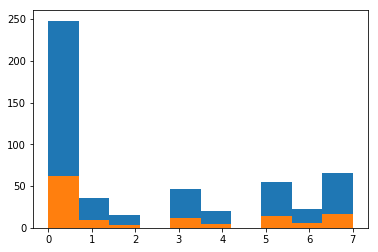

In [36]:
## divide train and test sets using the stratified shuffle split
# https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    train_dataset = X[train_index,:]
    train_labels = emotionHotID[train_index,:] #y[train_index]
    valid_dataset = X[test_index,:]
    valid_labels = emotionHotID[test_index,:] #y[test_index]
    
    test_dataset = X[test_index,:]
    test_labels = emotionHotID[test_index,:]  #y[test_index]    
    
#print(train_index) 
#print(test_index)
#print(train_labels)
#print(valid_labels)

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(y[train_index])
plt.hist(y[test_index])
## it's indeed stratified

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)


In [54]:
##################################################
## Single layer, fully connected 
##
## accuracy: 97.7%
##
##################################################
graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset)
  tf_train_labels = tf.constant(train_labels)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([input_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)


num_steps = 15001

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))


Initialized
Loss at step 0: 5747.574707
Training accuracy: 3.0%
Validation accuracy: 48.4%
Loss at step 100: 477633.812500
Training accuracy: 61.8%
Validation accuracy: 53.1%
Loss at step 200: 258892.171875
Training accuracy: 46.5%
Validation accuracy: 53.9%
Loss at step 300: 109822.804688
Training accuracy: 57.9%
Validation accuracy: 78.1%
Loss at step 400: 201393.296875
Training accuracy: 49.2%
Validation accuracy: 51.6%
Loss at step 500: 90067.734375
Training accuracy: 70.7%
Validation accuracy: 60.9%
Loss at step 600: 64709.425781
Training accuracy: 77.4%
Validation accuracy: 64.1%
Loss at step 700: 93232.867188
Training accuracy: 77.4%
Validation accuracy: 78.9%
Loss at step 800: 65173.234375
Training accuracy: 72.2%
Validation accuracy: 71.1%
Loss at step 900: 86861.023438
Training accuracy: 71.9%
Validation accuracy: 70.3%
Loss at step 1000: 34116.492188
Training accuracy: 74.2%
Validation accuracy: 64.1%
Loss at step 1100: 86114.562500
Training accuracy: 78.3%
Validation accura

Loss at step 10200: 0.000000
Training accuracy: 100.0%
Validation accuracy: 97.7%
Loss at step 10300: 0.000000
Training accuracy: 100.0%
Validation accuracy: 97.7%
Loss at step 10400: 0.000000
Training accuracy: 100.0%
Validation accuracy: 97.7%
Loss at step 10500: 0.000000
Training accuracy: 100.0%
Validation accuracy: 97.7%
Loss at step 10600: 0.000000
Training accuracy: 100.0%
Validation accuracy: 97.7%
Loss at step 10700: 0.000000
Training accuracy: 100.0%
Validation accuracy: 97.7%
Loss at step 10800: 0.000000
Training accuracy: 100.0%
Validation accuracy: 97.7%
Loss at step 10900: 0.000000
Training accuracy: 100.0%
Validation accuracy: 97.7%
Loss at step 11000: 0.000000
Training accuracy: 100.0%
Validation accuracy: 97.7%
Loss at step 11100: 0.000000
Training accuracy: 100.0%
Validation accuracy: 97.7%
Loss at step 11200: 0.000000
Training accuracy: 100.0%
Validation accuracy: 97.7%
Loss at step 11300: 0.000000
Training accuracy: 100.0%
Validation accuracy: 97.7%
Loss at step 114

In [62]:
## two layer model with ReLU in the hidden layer
##
## accuracy: 48.4%
##
## THIS IS NOT GOOD... BECAUSE LACK OF DATA???
###

import tensorflow as tf

batch_size = 256
hidden_size = 72
num_steps=9001

reg = 1e-2

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    W1 = tf.Variable(tf.truncated_normal([input_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))
    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))

    logits = tf.matmul(tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1), W2) + b2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    loss += reg * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))

    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1), W2) + b2)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1), W2) + b2)

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
    print("initialize all variables")
    tf.global_variables_initializer().run()
    
    print("start iterations")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0):
            print("step %d:" % step)
            print("  minibatch loss: %f" % l)
            print("  minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("  validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            
            #print(test_prediction.eval())
            #print(test_labels)
      

    print("test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

initialize all variables
start iterations
step 0:
  minibatch loss: 16108.234375
  minibatch accuracy: 5.9%
  validation accuracy: 48.4%
step 500:
  minibatch loss: 2809760.500000
  minibatch accuracy: 44.5%
  validation accuracy: 48.4%
step 1000:
  minibatch loss: 1703993.750000
  minibatch accuracy: 43.4%
  validation accuracy: 48.4%
step 1500:
  minibatch loss: 1033395.562500
  minibatch accuracy: 44.9%
  validation accuracy: 48.4%
step 2000:
  minibatch loss: 626708.250000
  minibatch accuracy: 45.7%
  validation accuracy: 48.4%
step 2500:
  minibatch loss: 380070.875000
  minibatch accuracy: 46.9%
  validation accuracy: 48.4%
step 3000:
  minibatch loss: 230496.484375
  minibatch accuracy: 47.3%
  validation accuracy: 48.4%
step 3500:
  minibatch loss: 139786.359375
  minibatch accuracy: 47.7%
  validation accuracy: 48.4%
step 4000:
  minibatch loss: 84774.757812
  minibatch accuracy: 46.9%
  validation accuracy: 48.4%
step 4500:
  minibatch loss: 51412.738281
  minibatch accuracy

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [57]:
## CNN  (NEED TO MATCH DIMENSIONS)

batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

num_channels=1

graph = tf.Graph()



with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, input_size, 1, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [input_size // 4 * 1 // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))



num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))


ValueError: Dimensions must be equal, but are 544 and 128 for 'MatMul' (op: 'MatMul') with input shapes: [16,544], [128,64].

In [58]:
shape

NameError: name 'shape' is not defined